# UCR Dataset: SyntheticControl

**Dataset Homepage:** https://timeseriesclassification.com/description.php?Dataset=SyntheticControl.

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Clustering (CNN-KMeans) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-3hdblqdz5nx4m).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/cnn-kmeans-algo-v1-2"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

### 2. Data preparation

#### 2.1 Training dataset

Load the training data.

In [3]:
training_dataset = pd.DataFrame(data=np.genfromtxt("SyntheticControl_TRAIN.txt"))

In [4]:
training_dataset.shape

(300, 61)

In [5]:
training_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.0,-0.376936,1.224864,0.343874,0.328454,-0.337609,1.026514,-1.330996,-0.657800,1.446077,...,0.370712,-1.568165,1.021863,-1.429748,1.356966,1.372781,0.663558,0.918346,-1.311742,-1.197146
1,1.0,0.644406,0.413269,-0.862278,-1.497386,-0.421458,-0.214215,-1.292131,0.956898,-1.216140,...,1.317268,-0.802528,-1.121287,0.989319,-1.109687,0.219856,0.630034,1.398140,0.085742,0.024997
2,1.0,-0.978667,-0.406232,0.822429,-1.408242,-1.676734,-0.490632,1.404598,1.168600,-1.703254,...,-0.828783,-0.762884,1.382972,-0.869103,1.277252,-0.198967,0.966809,0.666129,0.106996,0.082715
3,1.0,-0.236537,-0.098175,0.367092,1.366860,0.498281,-0.300223,1.715634,0.902108,-0.218132,...,0.068904,-1.499604,0.406744,1.289153,-1.119731,-0.995985,1.651135,-1.187098,0.025463,-0.841518
4,1.0,1.490735,1.325243,1.626829,-0.317056,-1.098990,-0.022213,0.596980,1.667339,-0.206153,...,0.815065,1.029995,-1.496161,-1.167442,1.484208,-0.373020,-0.843281,-0.209794,0.137724,0.716542


In [6]:
training_dataset.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6.])

In [7]:
training_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    50
2.0    50
3.0    50
4.0    50
5.0    50
6.0    50
Name: count, dtype: int64

Visualize the training data.

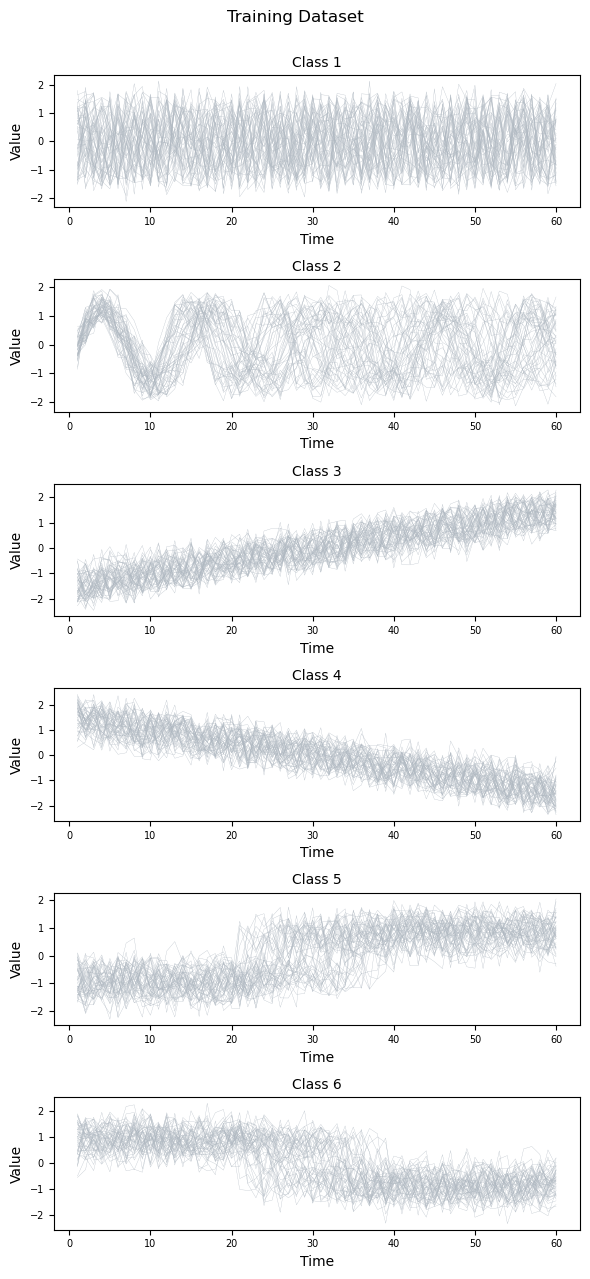

In [8]:
fig, axs = plt.subplots(nrows=training_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 13))
for i, c in enumerate(training_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.show()

Upload the training data to S3, make sure to remove the first column with the class labels.

In [9]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.iloc[:, 1:].to_csv(index=False, header=False),
    bucket=bucket,
    key="SyntheticControl_train.csv"
)

In [10]:
training_data

's3://sagemaker-eu-west-1-661670223746/SyntheticControl_train.csv'

#### 2.2 Test dataset

Load the test data.

In [11]:
test_dataset = pd.DataFrame(data=np.genfromtxt("SyntheticControl_TEST.txt"))

In [12]:
test_dataset.shape

(300, 61)

In [13]:
test_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.0,-1.413973,-1.162065,-0.624174,0.939604,-0.527501,0.574787,0.543176,1.748488,-0.505922,...,0.861244,0.404978,-0.894692,-0.363005,1.187356,-0.959220,-0.353210,1.363072,0.725540,-0.880089
1,1.0,-1.115918,0.237161,1.630814,-1.164521,-0.490658,-1.259363,-0.444532,-0.075867,0.501587,...,1.405396,-0.275376,-0.397296,0.536837,1.401524,0.813164,0.367139,-1.366535,-0.662661,-1.248914
2,1.0,-1.285745,-0.067465,-0.555322,1.265105,1.071486,-0.671687,0.165408,-1.248055,0.024684,...,-0.876705,1.650781,-0.942760,-1.383123,-0.764376,-1.370275,0.976808,-1.682904,0.891538,1.552039
3,1.0,0.104958,1.058988,1.413211,1.219300,0.025581,1.328026,1.506016,-1.324825,-0.477935,...,1.375449,0.154675,-1.795027,-0.244081,1.517773,1.541059,-1.187600,0.738079,0.205016,1.117345
4,1.0,-0.325845,0.276776,0.711680,1.336955,0.297444,1.209129,-0.468070,1.000695,0.689799,...,1.355817,-1.270352,0.029483,0.740501,0.656075,-1.647922,0.617990,-0.308325,1.294794,-1.177385


In [14]:
test_dataset.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6.])

In [15]:
test_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    50
2.0    50
3.0    50
4.0    50
5.0    50
6.0    50
Name: count, dtype: int64

Visualize the test data.

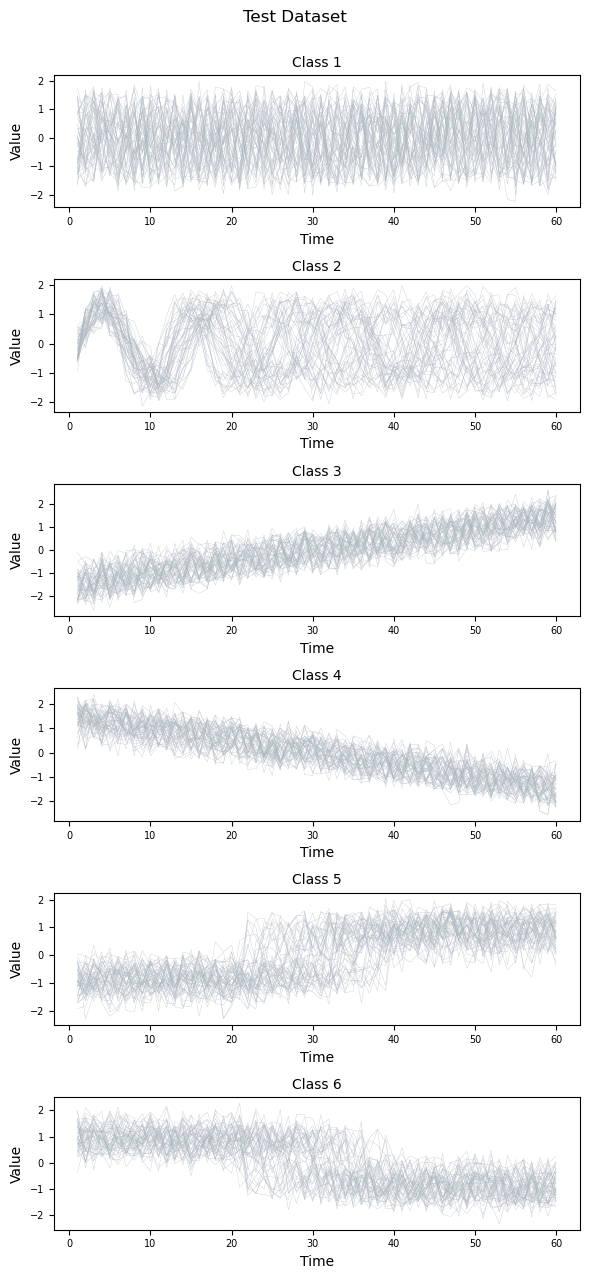

In [16]:
fig, axs = plt.subplots(nrows=test_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 13))
for i, c in enumerate(test_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[test_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.show()

Upload the test data to S3, make sure to remove the first column with the class labels.

In [17]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.iloc[:, 1:].to_csv(index=False, header=False),
    bucket=bucket,
    key="SyntheticControl_test.csv"
)

In [18]:
test_data

's3://sagemaker-eu-west-1-661670223746/SyntheticControl_test.csv'

### 3. Training

Fit the model to the training data.

In [19]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "clusters": 6,
        "algorithm": "lloyd",
        "blocks": 10,
        "filters": 40,
        "kernel-size": 3,
        "reduced-size": 160,
        "output-size": 320,
        "negative-samples": 10,
        "lr": 0.001,
        "batch-size": 128,
        "epochs": 100,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: cnn-kmeans-algo-v1-2-2023-08-17-14-30-18-178


2023-08-17 14:30:18 Starting - Starting the training job...
2023-08-17 14:30:32 Starting - Preparing the instances for training......
2023-08-17 14:31:23 Downloading - Downloading input data.........
2023-08-17 14:33:04 Training - Downloading the training image............
2023-08-17 14:35:00 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-17 14:35:30,522 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-17 14:35:30,523 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-17 14:35:30,524 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-17 14:35:30,524 sagemaker-training-toolkit INFO     Failed to parse hyperparameter algorithm value lloyd to Json.
Returning the value itself
2023-08-17 14:35:30,533 sagemaker_pytorc

### 4. Inference

Generate the test set predictions.

In [20]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: cnn-kmeans-algo-v1-2-2023-08-17-15-19-02-757


.........

INFO:sagemaker:Creating model with name: cnn-kmeans-algo-v1-2-2023-08-17-15-19-0-2023-08-17-15-19-48-336


INFO:sagemaker:Creating transform job with name: cnn-kmeans-algo-v1-2-2023-08-17-15-19-49-070


..........................................
2023-08-17T15:26:42,657 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-08-17T15:26:42,657 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-08-17T15:26:42,724 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-08-17T15:26:42,832 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.

Load the test set predictions from S3.

In [21]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/SyntheticControl_test.csv.out"
)

In [22]:
predictions = pd.DataFrame([x.split(",") for x in predictions.split("\n")[:-1]]).replace("", np.nan).astype(float)

In [23]:
predictions.shape

(300, 321)

In [24]:
predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,5.0,-0.002147,0.005140,0.213018,-0.136307,0.053295,-0.124957,0.274989,-0.131136,-0.114770,...,0.171548,-0.122196,0.018805,0.023152,0.001754,0.014681,-0.180175,0.086559,-0.200637,-0.094738
1,5.0,-0.052506,-0.083406,0.208230,-0.116170,0.119293,-0.150741,0.279283,-0.127313,-0.023785,...,0.120475,-0.134932,0.016089,-0.103683,0.058085,0.040865,-0.164498,0.018621,-0.149879,-0.031787
2,5.0,-0.079145,-0.060627,0.228601,-0.156009,0.042036,-0.083325,0.220279,-0.051412,-0.039276,...,0.053483,-0.040611,0.072384,-0.051242,0.118005,0.041161,-0.113355,0.078887,-0.167180,-0.099469
3,5.0,-0.071467,0.168331,0.133423,0.013699,-0.002167,-0.139059,-0.043615,-0.046502,0.087948,...,0.161406,-0.212611,-0.002417,-0.139018,-0.026259,0.224260,-0.106552,-0.044630,-0.250826,-0.120423
4,5.0,-0.093685,0.080533,0.189207,-0.062101,0.144524,-0.116025,0.073783,-0.087220,-0.011506,...,0.135643,-0.110743,-0.041886,-0.073875,0.002051,0.075607,-0.072832,-0.036364,-0.206663,-0.094907


In [25]:
predictions.iloc[:, 0].sort_values().unique()

array([0., 1., 2., 3., 4., 5.])

In [26]:
predictions.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    56
1.0    53
2.0    50
3.0    44
4.0    46
5.0    51
Name: count, dtype: int64

Calculate the Silhouette Coefficient.

In [27]:
silhouette_score(X=predictions.iloc[:, 1:], labels=predictions.iloc[:, 0])

0.35860105737892

Visualize the results.

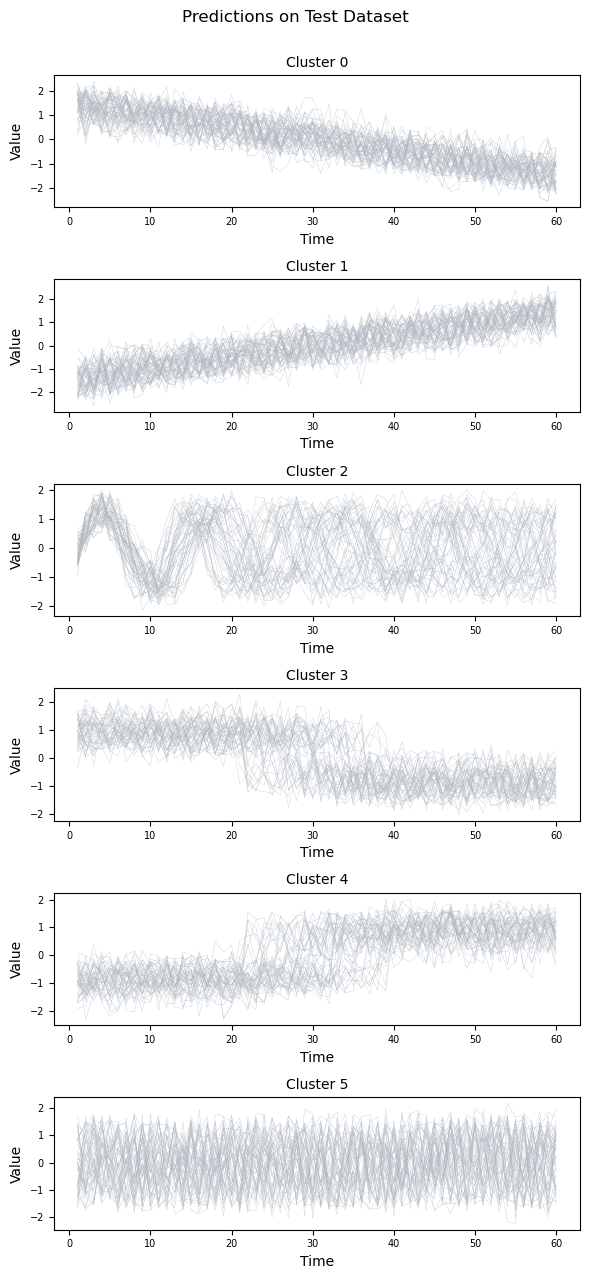

In [28]:
fig, axs = plt.subplots(nrows=predictions.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 13))
for i, c in enumerate(predictions.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[predictions.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Cluster {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Predictions on Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.show()